## Project: Sentiment Analysis with Custom Loss Function<br>
#### Part 3. Model train using vanilla loss function<br>


# Imports

In [1]:
import torch
import os
import time
import csv
from torch.utils.data import random_split, DataLoader
from torch.optim import AdamW
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt

from src.dataset import IMDBDataset
from src.model import SentimentClassifier
from src.loss import VanillaBCELoss, ClassifierMetrics
from src.utils import set_seed

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# device

In [2]:
set_seed(101)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Load datasets

In [4]:
# Load imdb datasets
raw_datasets = load_dataset("imdb")


# Split original imdb train/test into train/val/test
full_train_dataset = IMDBDataset(raw_datasets["train"])
test_dataset = IMDBDataset(raw_datasets["test"])

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

In [5]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 20000
Validation dataset size: 5000
Test dataset size: 25000


# Model and loss function build

In [6]:
model = SentimentClassifier().to(device)
loss_fn = VanillaBCELoss()
optimizer = AdamW(model.parameters(), lr=2e-5)

metrics = ClassifierMetrics(threshold=0.5)

# Main training

## checkpoint dir and last checkpoint

In [7]:
checkpoint_dir = "checkpoints_vanilla"
os.makedirs(checkpoint_dir, exist_ok=True)
resume_path = os.path.join(checkpoint_dir, "last_checkpoint.pt")
metrics_csv = os.path.join(checkpoint_dir, "metrics.csv")


## Logging variables

In [8]:
train_losses, val_losses = [], []
train_f1_scores, val_f1_scores = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
best_val_f1 = 0.0
start_epoch = 0

## Initial checkpoint load

In [9]:
if os.path.exists(resume_path):
    print("Resuming from checkpoint: {}".format(resume_path))
    checkpoint = torch.load(resume_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    train_f1_scores = checkpoint['train_f1_scores']
    val_f1_scores = checkpoint['val_f1_scores']
    train_precisions = checkpoint.get('train_precisions', [])
    train_recalls = checkpoint.get('train_recalls', [])
    val_precisions = checkpoint.get('val_precisions', [])
    val_recalls = checkpoint.get('val_recalls', [])
    best_val_f1 = checkpoint['best_val_f1']

## Set up logging file

In [10]:
if not os.path.exists(metrics_csv):
    with open(metrics_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "epoch",
            "train_loss", "train_precision", "train_recall", "train_f1",
            "val_loss", "val_precision", "val_recall", "val_f1"
        ])

## Training loop

In [11]:
total_epoch = 3

for epoch in range(start_epoch, total_epoch):
    print("Epoch {}\n".format(epoch + 1))
    start_time = time.time()

    model.train()
    total_loss = 0
    train_preds, train_labels = [], []

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        lengths = torch.tensor(batch['length'], dtype=torch.float32).to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels, lengths)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        train_preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        train_labels.extend(labels.detach().cpu().numpy())

    avg_train_loss = total_loss / len(train_loader)
    train_metrics = metrics.compute(train_labels, train_preds)
    train_losses.append(avg_train_loss)
    train_f1_scores.append(train_metrics["f1"])
    train_precisions.append(train_metrics["precision"])
    train_recalls.append(train_metrics["recall"])

    model.eval()
    total_val_loss = 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            lengths = torch.tensor(batch['length'], dtype=torch.float32).to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels, lengths)
            total_val_loss += loss.item()

            val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_metrics = metrics.compute(val_labels, val_preds)
    val_losses.append(avg_val_loss)
    val_f1_scores.append(val_metrics["f1"])
    val_precisions.append(val_metrics["precision"])
    val_recalls.append(val_metrics["recall"])

    print("Train loss: {:.4f} | Precision: {:.4f} | Recall: {:.4f} | F1: {:.4f}".format(
    avg_train_loss,
    train_metrics['precision'],
    train_metrics['recall'],
    train_metrics['f1']))

    print("Val   loss: {:.4f} | Precision: {:.4f} | Recall: {:.4f} | F1: {:.4f}".format(
        avg_val_loss,
        val_metrics['precision'],
        val_metrics['recall'],
        val_metrics['f1']))
    
    print("Epoch time: {:.2f} seconds".format(time.time() - start_time))

    # Save to CSV
    with open(metrics_csv, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            epoch + 1,
            avg_train_loss, train_metrics["precision"], train_metrics["recall"], train_metrics["f1"],
            avg_val_loss, val_metrics["precision"], val_metrics["recall"], val_metrics["f1"]
        ])

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_f1_scores': train_f1_scores,
        'val_f1_scores': val_f1_scores,
        'train_precisions': train_precisions,
        'train_recalls': train_recalls,
        'val_precisions': val_precisions,
        'val_recalls': val_recalls,
        'best_val_f1': best_val_f1
    }, resume_path)
    print(f"Saved checkpoint: {resume_path}")

    # Save best model
    if val_metrics["f1"] > best_val_f1:
        best_val_f1 = val_metrics["f1"]
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_model.pt"))
        print("Best model updated!")


Epoch 1



/tmp/ipykernel_2548/3748590709.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths = torch.tensor(batch['length'], dtype=torch.float32).to(device)
/tmp/ipykernel_2548/3748590709.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths = torch.tensor(batch['length'], dtype=torch.float32).to(device)


Train loss: 0.2614 | Precision: 0.8949 | Recall: 0.8897 | F1: 0.8923
Val   loss: 0.1976 | Precision: 0.9222 | Recall: 0.9237 | F1: 0.9230
Epoch time: 596.26 seconds
Saved checkpoint: checkpoints_vanilla/last_checkpoint.pt
Best model updated!
Epoch 2

Train loss: 0.1366 | Precision: 0.9523 | Recall: 0.9510 | F1: 0.9516
Val   loss: 0.2188 | Precision: 0.8861 | Recall: 0.9598 | F1: 0.9215
Epoch time: 593.28 seconds
Saved checkpoint: checkpoints_vanilla/last_checkpoint.pt
Epoch 3

Train loss: 0.0711 | Precision: 0.9777 | Recall: 0.9769 | F1: 0.9773
Val   loss: 0.2396 | Precision: 0.9366 | Recall: 0.9119 | F1: 0.9241
Epoch time: 603.16 seconds
Saved checkpoint: checkpoints_vanilla/last_checkpoint.pt
Best model updated!


## Results on Test dataset

In [ ]:
model.eval()
test_preds, test_labels = [], []
total_test_loss = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        lengths = torch.tensor(batch['length'], dtype=torch.float32).to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels, lengths)
        total_test_loss += loss.item()

        test_preds.extend(torch.sigmoid(outputs).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

avg_test_loss = total_test_loss / len(test_loader)
test_metrics = metrics.compute(test_labels, test_preds)

# Print final test results
print("Final Test Loss: {:.4f}".format(avg_test_loss))
print("Final Test Precision: {:.4f} | Recall: {:.4f} | F1: {:.4f}".format(
    test_metrics["precision"],
    test_metrics["recall"],
    test_metrics["f1"]
))


/tmp/ipykernel_2548/717335964.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths = torch.tensor(batch['length'], dtype=torch.float32).to(device)


# Plots

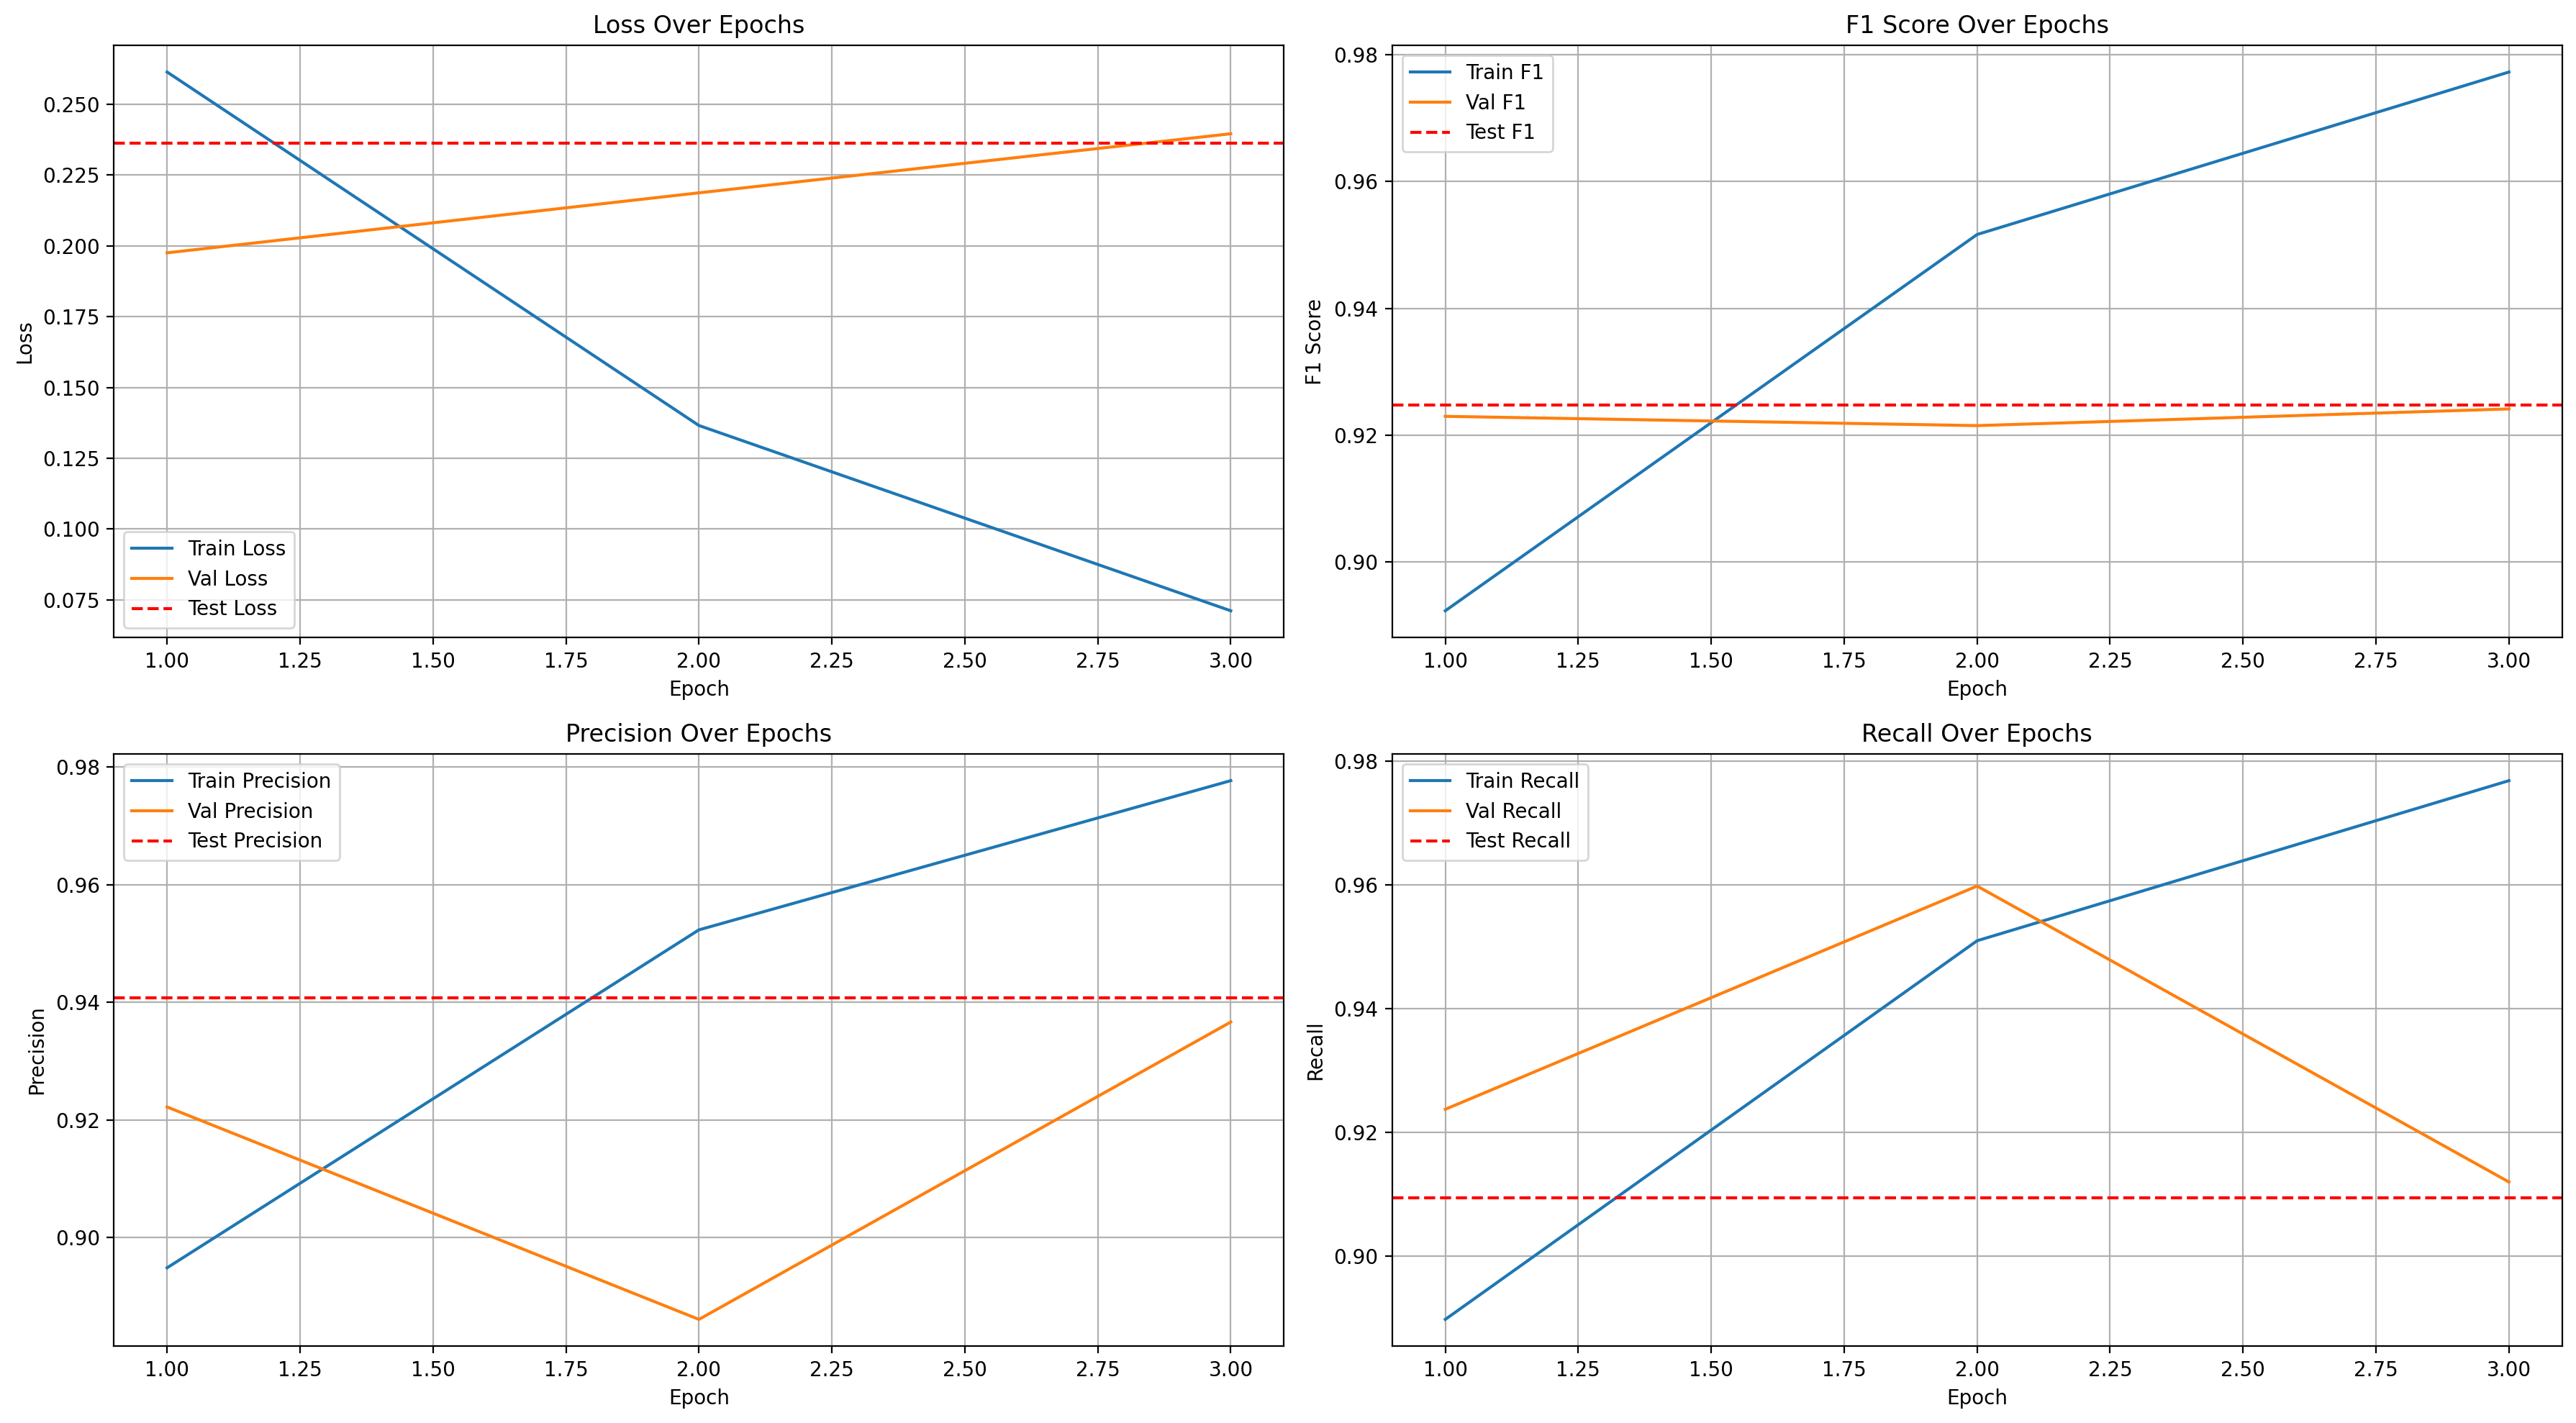

In [13]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.axhline(y=avg_test_loss, color="r", linestyle="--", label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(epochs, train_f1_scores, label="Train F1")
plt.plot(epochs, val_f1_scores, label="Val F1")
plt.axhline(y=test_metrics['f1'], color="r", linestyle="--", label="Test F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score Over Epochs")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(epochs, train_precisions, label="Train Precision")
plt.plot(epochs, val_precisions, label="Val Precision")
plt.axhline(y=test_metrics['precision'], color="r", linestyle="--", label="Test Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Precision Over Epochs")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(epochs, train_recalls, label="Train Recall")
plt.plot(epochs, val_recalls, label="Val Recall")
plt.axhline(y=test_metrics['recall'], color="r", linestyle="--", label="Test Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Recall Over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("assets/metrics_vanilla_loss.png")
plt.show()
